<a href="https://colab.research.google.com/github/divya4064/Hateful-Meme-Classifier/blob/main/Saliency.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Randomized Image Sampling for Explanations (RISE)

In [5]:
import os
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

from utils import *

from explanations import RISE

cudnn.benchmark = True

In [2]:
class Dummy:
    pass

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
#!unzip "/content/drive/MyDrive/misogynous.zip" -d "/content/data"


In [7]:
args = Dummy()

# Number of workers to load data
args.workers = 8
# Directory with images split into class folders.
# Since we don't use ground truth labels for saliency all images can be
# moved to one class folder.
args.datadir = '/content/data'
# Sets the range of images to be explained for dataloader.
args.range = range(95, 105)
# Size of imput images.
args.input_size = (224, 224)
# Size of batches for GPU.
# Use maximum number that the GPU allows.
args.gpu_batch = 250

In [6]:
print()

## Prepare data

In [8]:
dataset = datasets.ImageFolder(args.datadir, preprocess)


# This example only works with batch size 1. For larger batches see RISEBatch in explanations.py.
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=1, shuffle=False,
    num_workers=args.workers, pin_memory=True, sampler=RangeSampler(args.range))

print('Found {: >5} images belonging to {} classes.'.format(len(dataset), len(dataset.classes)))
print('      {: >5} images will be explained.'.format(len(data_loader) * data_loader.batch_size))

Found  9941 images belonging to 2 classes.
         10 images will be explained.


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## Load black-box model

In [9]:
# Load black box model for explanations
model = models.resnet50(True)
model = nn.Sequential(model, nn.Softmax(dim=1))
model = model.eval()
model = model.cuda()

for p in model.parameters():
    p.requires_grad = False

# To use multiple GPUs
model = nn.DataParallel(model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 161MB/s]


## Create explainer instance

In [10]:
explainer = RISE(model, args.input_size, args.gpu_batch)

In [11]:
# Generate masks for RISE or use the saved ones.
maskspath = 'masks.npy'
generate_new = True

if generate_new or not os.path.isfile(maskspath):
    explainer.generate_masks(N=6000, s=8, p1=0.1, savepath=maskspath)
else:
    explainer.load_masks(maskspath)
    print('Masks are loaded.')

Generating filters: 100%|██████████| 6000/6000 [00:23<00:00, 254.60it/s]


## Explaining one instance
Producing saliency maps for top $k$ predicted classes.

In [15]:
def example(img, top_k=3):
    saliency = explainer(img.cuda()).cpu().numpy()
    p, c = torch.topk(model(img.cuda()), k=top_k)
    p, c = p[0], c[0]

    plt.figure(figsize=(10, 5*top_k))
    for k in range(top_k):
        plt.subplot(top_k, 2, 2*k+1)
        plt.axis('off')
        plt.title('{:.2f}% {}'.format(100*p[k], get_class_name(c[k])))
        tensor_imshow(img[0])

        plt.subplot(top_k, 2, 2*k+2)
        plt.axis('off')
        plt.title(get_class_name(c[k]))
        tensor_imshow(img[0])
        sal = saliency[c[k]]
        plt.imshow(sal, cmap='jet', alpha=0.5)
        plt.colorbar(fraction=0.046, pad=0.04)

    plt.show()

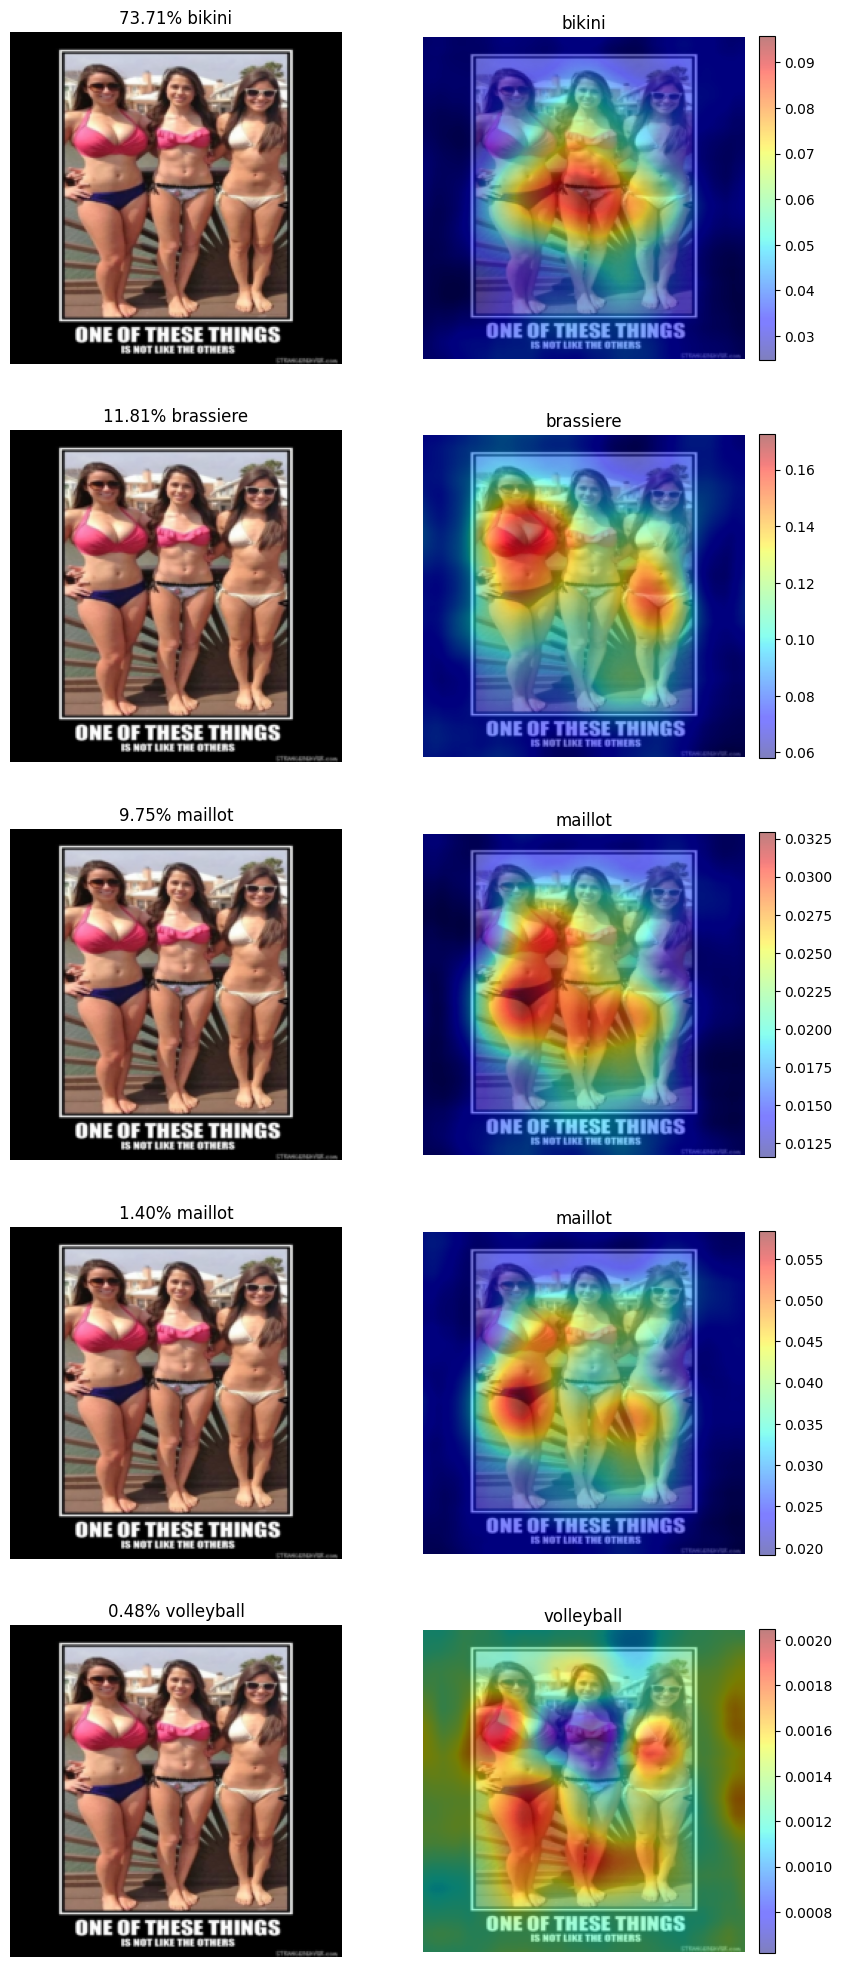

In [20]:
example(read_tensor('/content/data/misogynous/10021.jpg'), 5)

## Explaining all images in dataloader
Explaining the top predicted class for each image.

In [23]:
def explain_all(data_loader, explainer):
    # Get all predicted labels first
    target = np.empty(len(data_loader), int)
    for i, (img, _) in enumerate(tqdm(data_loader, total=len(data_loader), desc='Predicting labels')):
        p, c = torch.max(model(img.cuda()), dim=1)
        target[i] = c[0]

    # Get saliency maps for all images in val loader
    explanations = np.empty((len(data_loader), *args.input_size))
    for i, (img, _) in enumerate(tqdm(data_loader, total=len(data_loader), desc='Explaining images')):
        saliency_maps = explainer(img.cuda())
        explanations[i] = saliency_maps[target[i]].cpu().numpy()
    return explanations

In [24]:
explanations = explain_all(data_loader, explainer)

# Save explanations if needed.
# explanations.tofile('exp_{:05}-{:05}.npy'.format(args.range[0], args.range[-1]))

Predicting labels:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Explaining images: 100%|██████████| 10/10 [02:40<00:00, 16.04s/it]


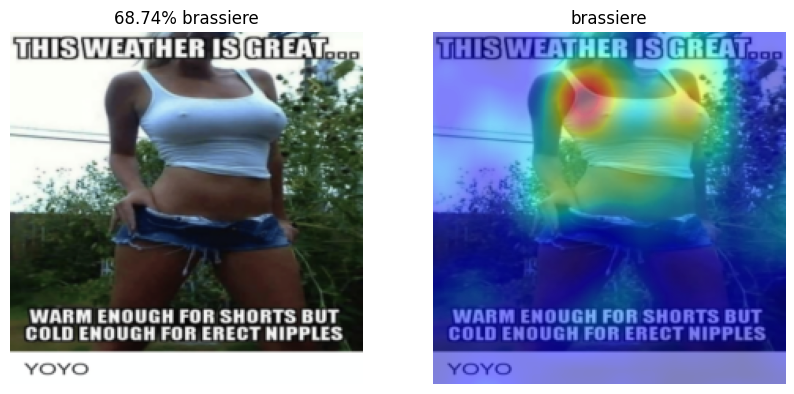

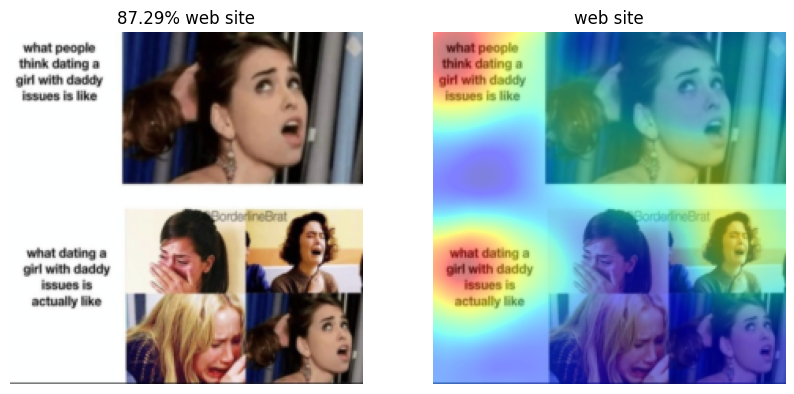

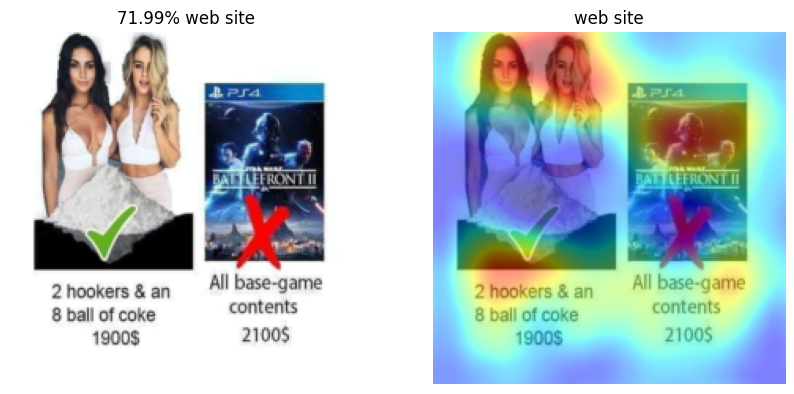

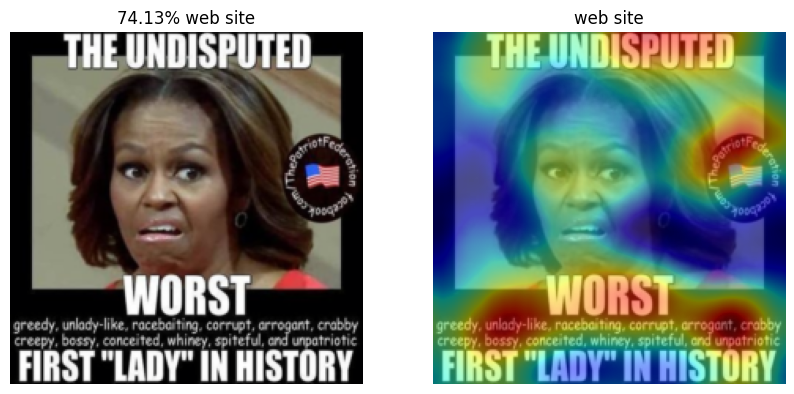

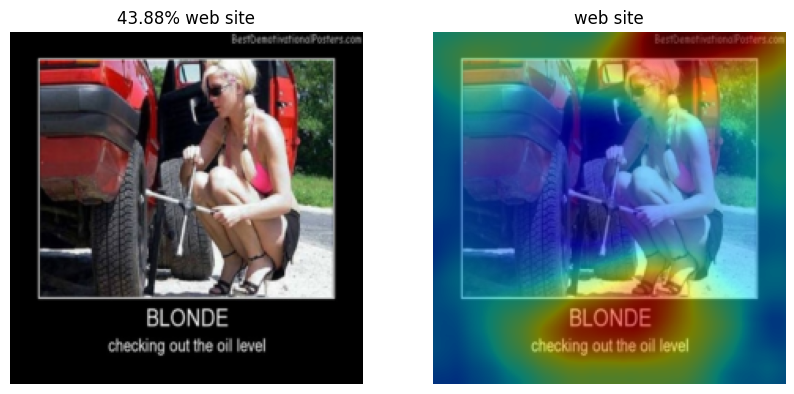

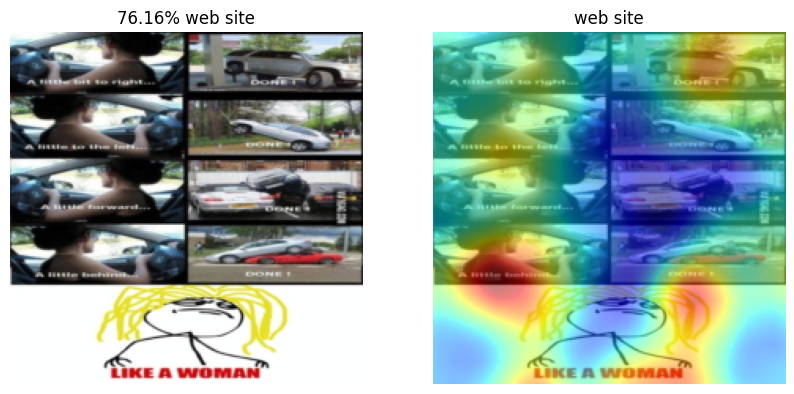

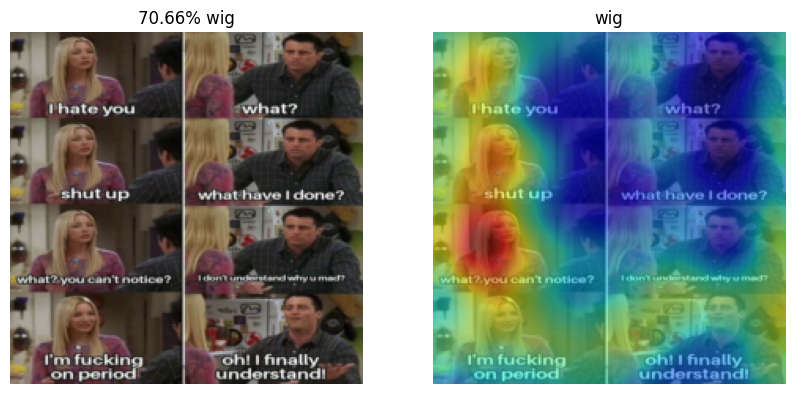

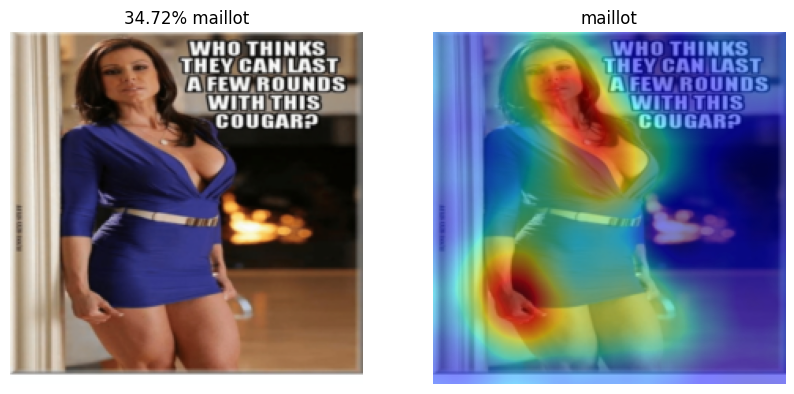

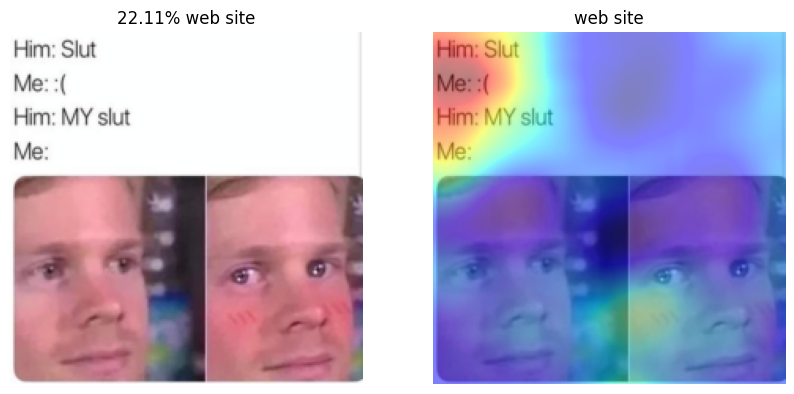

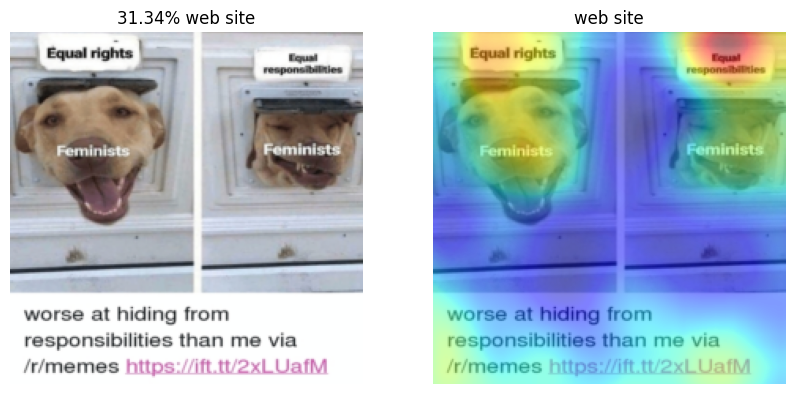

In [25]:
for i, (img, _) in enumerate(data_loader):
    p, c = torch.max(model(img.cuda()), dim=1)
    p, c = p[0].item(), c[0].item()

    plt.figure(figsize=(10, 5))
    plt.subplot(121)
    plt.axis('off')
    plt.title('{:.2f}% {}'.format(100*p, get_class_name(c)))
    tensor_imshow(img[0])

    plt.subplot(122)
    plt.axis('off')
    plt.title(get_class_name(c))
    tensor_imshow(img[0])
    sal = explanations[i]
    plt.imshow(sal, cmap='jet', alpha=0.5)
    #plt.colorbar(fraction=0.046, pad=0.04)

    plt.show()